In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\PC\Data\ads_fraud_detection
c:/Users/PC/Data/ads_fraud_detection


In [2]:
save_dir=f"{exps_dir}/exp2/exp_smote"
if os.path.exists(save_dir) == False:
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [3]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['Age',
  'AgeOfPolicyHolder',
  'AgentType',
  'BasePolicy',
  'Fault',
  'MaritalStatus',
  'PoliceReportFiled',
  'PolicyType',
  'VehicleCategory',
  'WitnessPresent'],
 'LDA': ['AccidentArea',
  'AddressChange_Claim',
  'Age',
  'AgeOfPolicyHolder',
  'BasePolicy',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'VehicleCategory'],
 'DTC': ['Age',
  'AgeOfVehicle',
  'BasePolicy',
  'Fault',
  'Make',
  'PastNumberOfClaims',
  'PolicyNumber',
  'RepNumber',
  'week_claimed',
  'week_incident'],
 'RD': ['Age',
  'AgeOfVehicle',
  'BasePolicy',
  'Fault',
  'Make',
  'PolicyNumber',
  'PolicyType',
  'VehicleCategory',
  'week_claimed',
  'week_incident'],
 'LGBM': ['Age',
  'AgeOfPolicyHolder',
  'AgeOfVehicle',
  'Make',
  'Month',
  'PolicyNumber',
  'RepNumber',
  'VehiclePrice',
  'week_claimed',
  'week_incident'],
 'XGB': ['Age',
  'AgeOfPolicyHolder',
  'AgeOfVehicle',
  'BasePolicy',
  'Deductible',
  'Fault',
  'Make',
  'MaritalStatus',
  '

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def train_model(best_model, x_train, y_train, features):
    x = x_train[features]
    for train_index, _ in kfold.split(x):
        X_train_fold, y_train_fold = x_train.iloc[train_index][features], y_train.iloc[train_index]
        
        # Huấn luyện mô hình tốt nhất trên fold hiện tại
        best_model.fit(X_train_fold, y_train_fold)
    return best_model


In [5]:
xgb_model=joblib.load(f'{save_dir}/xgb_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
lgbm_model=joblib.load(f'{save_dir}/lgbm_model.joblib')

In [6]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [7]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)

    labels_reshaped = labels.reshape(-1, 1)

    encoder.fit(labels_reshaped)

    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (19430, 2)


In [8]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [9]:
x_test.shape

(5089, 34)

In [10]:
x_train.shape

(19430, 34)

In [11]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    macro_f1_score = K.mean(f1_scores)

    return macro_f1_score

In [12]:
print(x_train.shape[1])

34


#### * Xây dựng model:

In [13]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



#### * Xây dựng Stacked_model:

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tensorflow as tf
from tabnet_keras import TabNetClassifier

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        self.model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid',**self.kwargs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy',f1_score])

        self.model.fit(X, y, epochs=5, batch_size=128, class_weight={0:0.45,1:0.6})
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        return (proba > 0.3).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)

    def summary(self):
        return self.model.summary()

In [26]:
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3,
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}
tabnet = TabNetWrapper(**tabnet_params)


In [16]:
best_model1 = train_model(LogisticRegression(class_weight='balanced', random_state=seed),x_train=x_train,y_train=y_train,features=feature_selection['LR'])
best_model2=train_model(SVC(kernel='rbf', gamma='scale', class_weight='balanced',probability=True, random_state=seed),x_train=x_train,y_train=y_train,features=feature_selection['SVM'])
best_model3=train_model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),x_train=x_train,y_train=y_train,features=feature_selection['BG'])


In [27]:
from sklearn.ensemble import StackingClassifier



# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict_proba(x_train[feature_selection['RD']])
svm_pred = lgbm_model.predict_proba(x_train[feature_selection['LGBM']])
bg_pred = xgb_model.predict_proba(x_train[feature_selection['XGB']])
best_model1_pred = best_model1.predict_proba(x_train[feature_selection['LR']])
best_model2_pred = best_model2.predict_proba(x_train[feature_selection['SVM']])
best_model3_pred = best_model3.predict_proba(x_train[feature_selection['BG']])



# keras_pred = tabnet.predict(x_test)
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred, best_model1_pred, best_model2_pred, best_model3_pred))


#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

# tabnet = KerasClassifier(build_fn=model_output, tabnet_params=tabnet_params,batch_size=64,epochs=10000,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
# tabnet = clone(tabnet)
# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    estimators=[('rf',rf_model), ('lgbm',lgbm_model),('xgb',xgb_model)],
    final_estimator=tabnet
)
print(stacked_input.shape)
print(y_test.shape)
# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_train)
# stacked_pred = stacked_model.predict(x_test)
# stacked_pred

(19430, 12)
(5089, 1)
[LightGBM] [Info] Number of positive: 9715, number of negative: 9715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 19430, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight={0: 0.5317035512094699,
                                                                     1: 8.385551948051948},
                                                       n_estimators=50,
                                                       random_state=7)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=1.0, max_depth=5,
                                               n_estimators=200,
                                               random_state=42,
                                               subsample=0.8)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.2, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=7, ...))],
                   final_estimator=TabNetWrapper())

In [28]:
rf_pred = rf_model.predict_proba(x_test[feature_selection['RD']])
svm_pred = lgbm_model.predict_proba(x_test[feature_selection['LGBM']])
bg_pred = xgb_model.predict_proba(x_test[feature_selection['XGB']])
best_model1_pred = best_model1.predict_proba(x_test[feature_selection['LR']])
best_model2_pred = best_model2.predict_proba(x_test[feature_selection['SVM']])
best_model3_pred = best_model3.predict_proba(x_test[feature_selection['BG']])
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred, best_model1_pred, best_model2_pred, best_model3_pred))
stacked_pred = stacked_model.predict(stacked_input)


160/160 [==============================] - 0s 910us/step


In [29]:
# stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
# stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_labels = (stacked_pred > 0.3).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_labels)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

Accuracy of Stacked Model: 0.7698958538023187


#### * Kết quả đánh giá mô hình:

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




accuracy = accuracy_score(y_test, stacked_pred_labels)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, stacked_pred_labels,labels=[1,0]))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7698958538023187
Classification Report:
              precision    recall  f1-score   support

           1       0.15      0.63      0.25       307
           0       0.97      0.78      0.86      4782

    accuracy                           0.77      5089
   macro avg       0.56      0.71      0.56      5089
weighted avg       0.92      0.77      0.83      5089



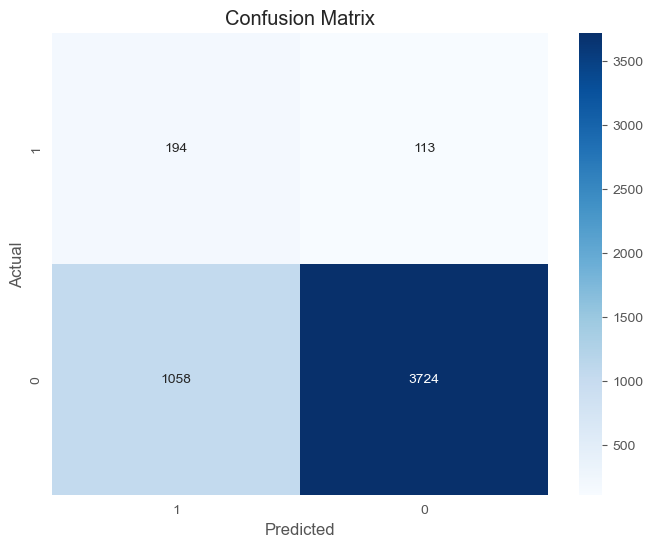

In [31]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred_labels,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

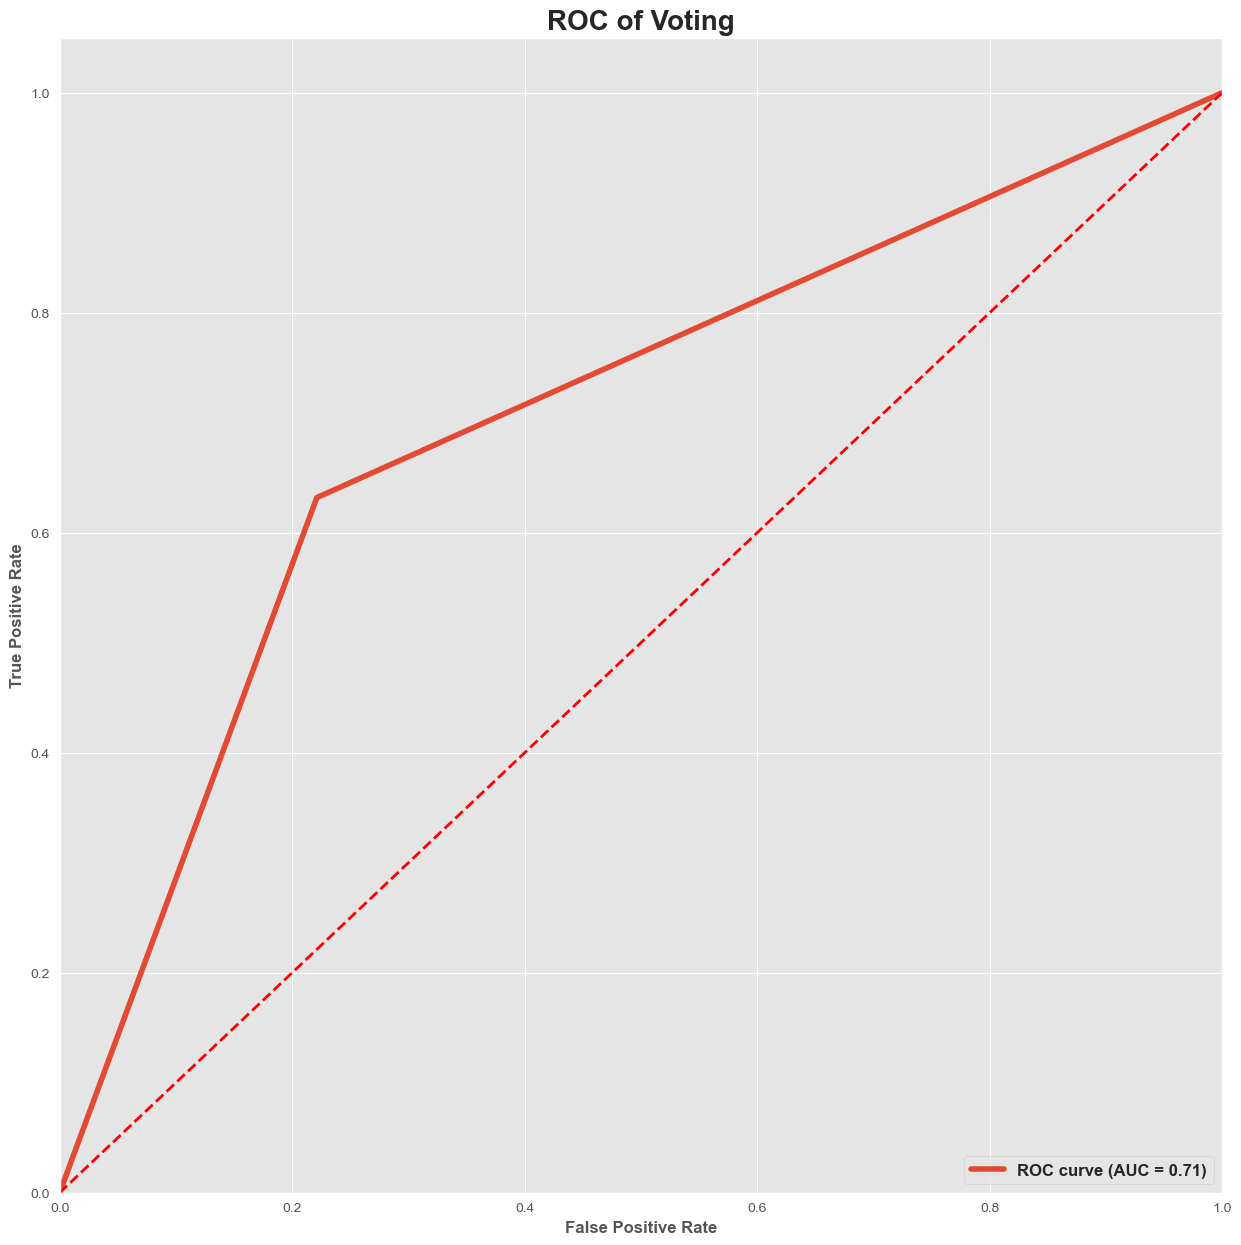

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, stacked_pred)

roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()

In [23]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [24]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    stacked_pred_labels = y_predict.argmax(axis=1)

    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(stacked_pred_labels[indx]))
    print("----------------------------")
    if Y_check==check_result(stacked_pred_labels[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1


160/160 [==============================] - 0s 924us/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
